In [8]:
import pandas as pd
nodo = 2
periodo = 3
nodosp={}
for i in [2,3,5]:
    nodosp[i] = pd.read_csv('nodo%d_periodo%d.csv'%(i,periodo),
                                           parse_dates=True,index_col=0)

In [21]:
################ 
df = nodosp[2].iloc[0:4801,:]
################ 
import numpy as np 
def random_sample(len_timeseries=3000): 
    Nchoice = 600 
    x1 = df.TEMPERATURA[0:-1]
    x2 = df['HUMEDAD RELATIVA'][0:-1]
    x3 = df['HUMEDAD DE LA TIERRA'][0:-1]
    x4 = df['HORA'][1::]
    y1 = df.TEMPERATURA[1::]
    y2 = df['HUMEDAD RELATIVA'][1::]
    y3 = df['HUMEDAD DE LA TIERRA'][1::]
    for t in range(3,len_timeseries): 
     ## the output time series depend on input as follows: 
     y1[t] = x1[t-2] 
     y2[t] = x2[t-1]*x3[t-2] 
     y3[t] = x4[t-3] 
    y = np.array([y1,y2,y3]).T 
    X = np.array([x1,x2,x3,x4]).T 
    return y, X 
def generate_data(Nsequence = 1000): 
    X_train = [] 
    y_train = [] 
    for isequence in range(Nsequence): 
     y, X = random_sample() 
     X_train.append(X) 
     y_train.append(y) 
    return np.array(X_train),np.array(y_train) 

Nsequence = 100 
prop = 0.5 
Ntrain = int(Nsequence*prop) 
X, y = generate_data(Nsequence) 
X_train = X[:Ntrain,:,:] 
X_test = X[Ntrain:,:,:] 
y_train = y[:Ntrain,:,:] 
y_test = y[Ntrain:,:,:] 

#X.shape = (N sequence, length of time series, N input features) 
#y.shape = (N sequence, length of time series, N targets) 
print(X.shape, y.shape) 
# (100, 3000, 4) (100, 3000, 3) 

#################### 
# Cutting function # 
#################### 

C:\Users\Jergb\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Jergb\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


(100, 4800, 4) (100, 4800, 3)


**Modo de estado con N = batch_size.** Los modelos de estado sólido son difíciles con Keras, porque debe tener cuidado con la forma en que corta las series de tiempo y selecciona el tamaño del lote. En la pregunta OP, el tamaño de muestra es N = 100. Dado que podemos aceptar entrenar el modelo con un lote de cien (no es un número grande), seleccionaremos batch_size = 100.

La selección de batch_size = N simplifica la capacitación porque no es necesario reiniciar estados dentro de épocas (por lo que no es necesario escribir una devolución de llamada on_batch_begin).

Sigue siendo una cuestión de cortar la serie temporal. Cortar es un poco técnico, así que escribí una función de envoltura que funcionaba en todos los casos.

In [22]:
def stateful_cut(arr, batch_size, T_after_cut): 
    if len(arr.shape) != 3: 
     # N: Independent sample size, 
     # T: Time length, 
     # m: Dimension 
     print("ERROR: please format arr as a (N, T, m) array.") 

    N = arr.shape[0] 
    T = arr.shape[1] 

    # We need T_after_cut * nb_cuts = T 
    nb_cuts = int(T/T_after_cut) 
    if nb_cuts * T_after_cut != T: 
     print("ERROR: T_after_cut must divide T") 

    # We need batch_size * nb_reset = N 
    # If nb_reset = 1, we only reset after the whole epoch, so no need to reset 
    nb_reset = int(N/batch_size) 
    if nb_reset * batch_size != N: 
     print("ERROR: batch_size must divide N") 

    # Cutting (technical) 
    cut1 = np.split(arr, nb_reset, axis=0) 
    cut2 = [np.split(x, nb_cuts, axis=1) for x in cut1] 
    cut3 = [np.concatenate(x) for x in cut2] 
    cut4 = np.concatenate(cut3) 
    return(cut4) 

A partir de ahora, que se convierta en fácil de entrenar el modelo. Dado que el ejemplo OP es muy simple, no necesitamos preprocesamiento o regularización adicional. Describo cómo proceder paso a paso (para el impaciente, todo el código autónomo está disponible al final de esta publicación).

Primero cargamos los datos y los reformamos con la función de envoltura.

In [23]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, TimeDistributed 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 

## 
# Data 
## 
N = X_train.shape[0] # size of samples 
T = X_train.shape[1] # length of each time series 
batch_size = N # number of time series considered together: batch_size | N 
T_after_cut = 100 # length of each cut part of the time series: T_after_cut | T 
dim_in = X_train.shape[2] # dimension of input time series 
dim_out = y_train.shape[2] # dimension of output time series 

inputs, outputs, inputs_test, outputs_test = [stateful_cut(arr, batch_size, T_after_cut) for arr in [X_train, y_train, X_test, y_test]] 

Luego compila un modelo con 4 entradas, 3 salidas, y 1 capa oculta contiene 10 nodos.

In [24]:
## 
# Model 
## 
nb_units = 10 

model = Sequential() 
model.add(LSTM(batch_input_shape=(batch_size, None, dim_in), 
       return_sequences=True, units=nb_units, stateful=True)) 
model.add(TimeDistributed(Dense(activation='linear', units=dim_out))) 
model.compile(loss = 'mse', optimizer = 'rmsprop') 

Formamos el modelo sin restablecer los estados. Podemos hacerlo sólo porque hemos seleccionado batch_size = N.

In [25]:
## 
# Training 
## 
epochs = 100 

nb_reset = int(N/batch_size) 
if nb_reset > 1: 
    print("ERROR: We need to reset states when batch_size < N") 

# When nb_reset = 1, we do not need to reinitialize states 
history = model.fit(inputs, outputs, epochs = epochs, 
        batch_size = batch_size, shuffle=False, 
        validation_data=(inputs_test, outputs_test)) 

Train on 2400 samples, validate on 2400 samples
Epoch 1/100
2400/2400 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 2/100
2400/2400 [==============================] - 2s 859us/step - loss: nan - val_loss: nan
Epoch 3/100
2400/2400 [==============================] - 2s 910us/step - loss: nan - val_loss: nan
Epoch 4/100
2400/2400 [==============================] - 2s 1ms/step - loss: nan - val_loss: nan
Epoch 5/100
2400/2400 [==============================] - 2s 880us/step - loss: nan - val_loss: nan
Epoch 6/100
2400/2400 [==============================] - 2s 845us/step - loss: nan - val_loss: nan
Epoch 7/100
2400/2400 [==============================] - 2s 842us/step - loss: nan - val_loss: nan
Epoch 8/100
2400/2400 [==============================] - 2s 848us/step - loss: nan - val_loss: nan
Epoch 9/100
2400/2400 [==============================] - 2s 840us/step - loss: nan - val_loss: nan
Epoch 10/100
2400/2400 [==============================] - 2s 845u

2400/2400 [==============================] - 2s 981us/step - loss: nan - val_loss: nan
Epoch 84/100
2400/2400 [==============================] - 2s 932us/step - loss: nan - val_loss: nan
Epoch 85/100
2400/2400 [==============================] - 2s 896us/step - loss: nan - val_loss: nan
Epoch 86/100
2400/2400 [==============================] - 2s 883us/step - loss: nan - val_loss: nan
Epoch 87/100
2400/2400 [==============================] - 2s 927us/step - loss: nan - val_loss: nan
Epoch 88/100
2400/2400 [==============================] - 2s 1ms/step - loss: nan - val_loss: nan
Epoch 89/100
2400/2400 [==============================] - 2s 871us/step - loss: nan - val_loss: nan
Epoch 90/100
2400/2400 [==============================] - 2s 914us/step - loss: nan - val_loss: nan
Epoch 91/100
2400/2400 [==============================] - 2s 1000us/step - loss: nan - val_loss: nan
Epoch 92/100
2400/2400 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 93/100
240

Nos obtener la evolución de la pérdida de entrenamiento/prueba de la siguiente manera:

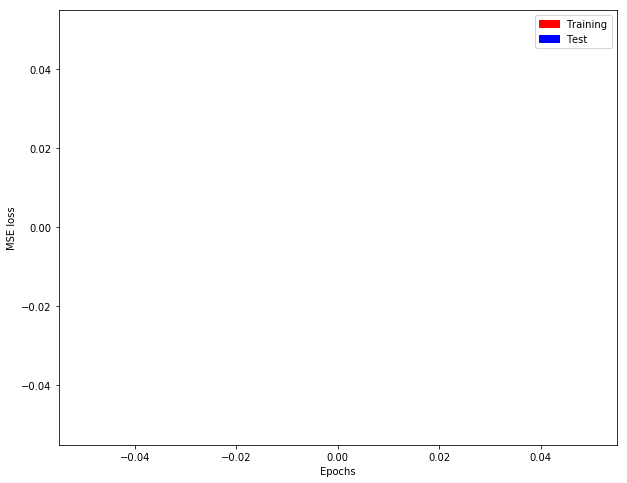

In [26]:
def plotting(history): 
    plt.plot(history.history['loss'], color = "red") 
    plt.plot(history.history['val_loss'], color = "blue") 
    red_patch = mpatches.Patch(color='red', label='Training') 
    blue_patch = mpatches.Patch(color='blue', label='Test') 
    plt.legend(handles=[red_patch, blue_patch]) 
    plt.xlabel('Epochs') 
    plt.ylabel('MSE loss') 
    plt.show() 

plt.figure(figsize=(10,8)) 
plotting(history) # Evolution of training/test loss 

Ahora, definimos un 'modelo mimo' que es apátrida pero contiene nuestros pesos de estado. [¿Por qué de esta manera? Predicción con modelo con estado a través de model.predict necesita un lote completo en Keras, pero es posible que no tengamos un lote completo para predecir ...]

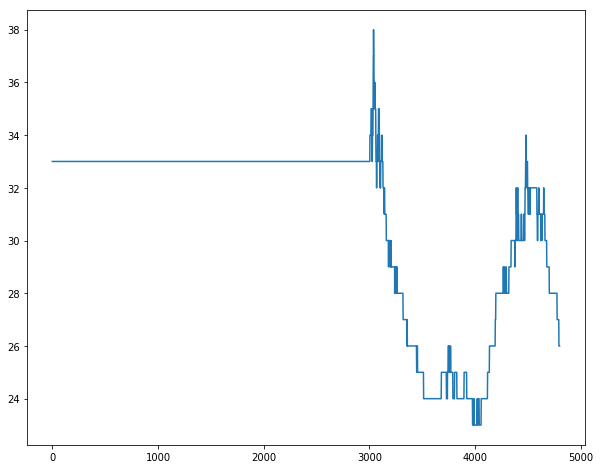

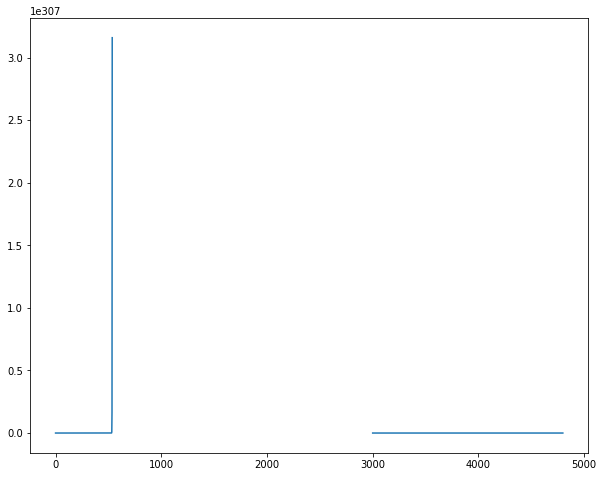

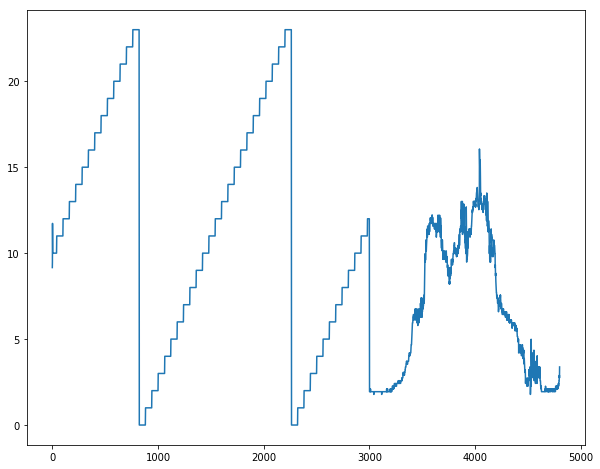

In [27]:
## 
# Visual checking for a time series 
## 
## Mime model which is stateless but containing stateful weights 
model_stateless = Sequential() 
model_stateless.add(LSTM(input_shape=(None, dim_in), 
       return_sequences=True, units=nb_units)) 
model_stateless.add(TimeDistributed(Dense(activation='linear', units=dim_out))) 
model_stateless.compile(loss = 'mse', optimizer = 'rmsprop') 
model_stateless.set_weights(model.get_weights()) 

## Prediction of a new set 
i = 0 # time series selected (between 0 and N-1) 
x = X_train[i] 
y = y_train[i] 
y_hat = model_stateless.predict(np.array([x]))[0] 

for dim in range(3): # dim = 0 for y1 ; dim = 1 for y2 ; dim = 2 for y3. 
    plt.figure(figsize=(10,8)) 
    plt.plot(range(T), y[:,dim]) 
    plt.plot(range(T), y_hat[:,dim]) 
    plt.show() 

## Conclusion: works almost perfectly. 

In [6]:
len(X_train)

50